In [10]:
import pandas as pd
import numpy as np
import torch
import cv2
from torchvision.transforms import ToTensor
import albumentations as alb

In [5]:
df = pd.read_csv("../input/train.csv")
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [11]:
a = cv2.imread(f"../input/train/{df.Id.iloc[0]}.jpg")

In [13]:
b = ToTensor()(a)

In [15]:
b.shape

torch.Size([3, 720, 405])

In [17]:
b.std()

tensor(0.1888)

In [21]:
import sklearn

In [33]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.1, random_state=0)

In [35]:
df_train = df_train.reset_index(drop=True)

In [42]:
df_train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,1a8795e64a294ed0c95132e18ee198e1,0,1,1,1,0,0,0,0,0,0,0,0,55
1,08ce774252e822838bf598aa10518a11,0,1,1,1,0,0,0,0,0,0,0,0,100
2,a71c677d87606a56160b70c5f6fa4526,0,1,1,0,0,0,0,0,0,0,0,0,27
3,11d5914ad80403375c8e0ccd959fc08e,0,1,1,1,0,0,0,0,0,0,0,0,51
4,c04034bbfe0a0d89729541c2271a674e,0,1,1,1,0,0,0,0,0,0,0,0,48


In [41]:
df_train.iloc[0]["Pawpularity"]

55

In [30]:
a[0].reset_index(drop=True)

0       50ecb023e6d62ea3294649df55f67563
1       436afe662e12baf17b5e78fea2b112a3
2       20a9b0332beba5860008ce0469ae375c
3       5e86f858cf18930e131b8c5a93fea90d
4       fb861439b9b921c91bef07a2229e756f
                      ...               
7429    f780c46f431ffc5a6cfa067c5ab08b8d
7430    46a9243003c2603d4e406f879ebe77c8
7431    92b555a971cc0159d3b9e2fb15d7dfd4
7432    d0e09f82a02426e9b604173e5d7b05dc
7433    95c12cb572dc027e2f00243ceb548838
Name: Id, Length: 7434, dtype: object

In [31]:
df_train = a[0]

In [32]:
df_train.head()

3114    50ecb023e6d62ea3294649df55f67563
2611    436afe662e12baf17b5e78fea2b112a3
1264    20a9b0332beba5860008ce0469ae375c
3694    5e86f858cf18930e131b8c5a93fea90d
9741    fb861439b9b921c91bef07a2229e756f
Name: Id, dtype: object

In [220]:
import albumentations as alb
from albumentations.pytorch.transforms import ToTensorV2

def get_transforms(is_train=True, visualize=False):
    tfms = [
        alb.LongestMaxSize(max_size=224),
        alb.PadIfNeeded(min_height=224, min_width=224),
    ]
    if is_train:
        tfms += [
            alb.HorizontalFlip(p=0.5),
            alb.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02, always_apply=False, p=0.75)
        ]

    if not visualize:
        tfms += [alb.Normalize(), ToTensorV2()]

    return alb.Compose(tfms)

In [225]:
class PawpularityDataset:
    def __init__(self, dataframe, is_train, visualize, get_transforms_func):
        df_split = train_test_split(dataframe, test_size=0.1, random_state=0)
        df = df_split[0] if is_train else df_split[1]
        self.df = df.reset_index(drop=True)
        self.is_train = is_train
        self.visualize = visualize
        self.get_transforms_func = get_transforms_func

    def __getitem__(self, idx):
        filename = self.df.iloc[idx]["Id"]
        image = cv2.imread(f"../input/{('train' if self.is_train else 'val')}/{filename}.jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.get_transforms_func(self.is_train, self.visualize)(image=image)["image"]
        target = self.df.iloc[idx]["Pawpularity"]
        return image, target

    def __len__(self):
        return len(self.df)

In [226]:
ds = PawpularityDataset(df, is_train=True, visualize=False, get_transforms_func=get_transforms)

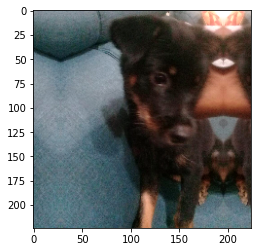

In [228]:
import matplotlib.pyplot as plt
ds2 = PawpularityDataset(df, is_train=True, visualize=True, get_transforms_func=get_transforms)
plt.imshow(ds2[935][0])

In [53]:
ds[0]

(tensor([[[-0.8507, -0.8507, -0.9192,  ...,  1.5125,  1.4954,  1.4954],
          [-0.9192, -0.9192, -0.9877,  ...,  1.5297,  1.5297,  1.5297],
          [-1.0390, -1.0390, -1.0562,  ...,  1.5297,  1.5297,  1.5297],
          ...,
          [-0.1486, -0.1314, -0.0801,  ...,  2.0777,  2.0605,  2.0263],
          [ 0.1768, -0.0972, -0.0972,  ...,  2.0605,  2.0434,  2.0263],
          [ 0.2453,  0.2111, -0.0287,  ...,  2.0605,  2.0434,  2.0263]],
 
         [[-0.6352, -0.6527, -0.7052,  ...,  1.5357,  1.5182,  1.5182],
          [-0.7052, -0.7052, -0.7752,  ...,  1.5532,  1.5532,  1.5532],
          [-0.8277, -0.8277, -0.8452,  ...,  1.5532,  1.5532,  1.5532],
          ...,
          [-0.0924, -0.0924, -0.0049,  ...,  2.2360,  2.2360,  2.2010],
          [ 0.2402, -0.0399, -0.0399,  ...,  2.2360,  2.2185,  2.2010],
          [ 0.3102,  0.2927,  0.0301,  ...,  2.2360,  2.2185,  2.2010]],
 
         [[-0.4101, -0.4275, -0.4798,  ...,  1.5594,  1.5420,  1.5420],
          [-0.4798, -0.4798,